In [22]:
%matplotlib inline

import pandas as pd
import numpy as np
import aplusml

PATH_TO_YAML: str = '../workflows/acp_jung_replication.yaml'
PATH_TO_PATIENT_PROPERTIES: str = '../input/synthetic_acp_inputs.csv'

# Goal

To replicate the graphs in [Jung et al. 2021](https://academic.oup.com/jamia/article/28/6/1149/6045012)

# Load the Workflow

Load our workflow from the YAML file:

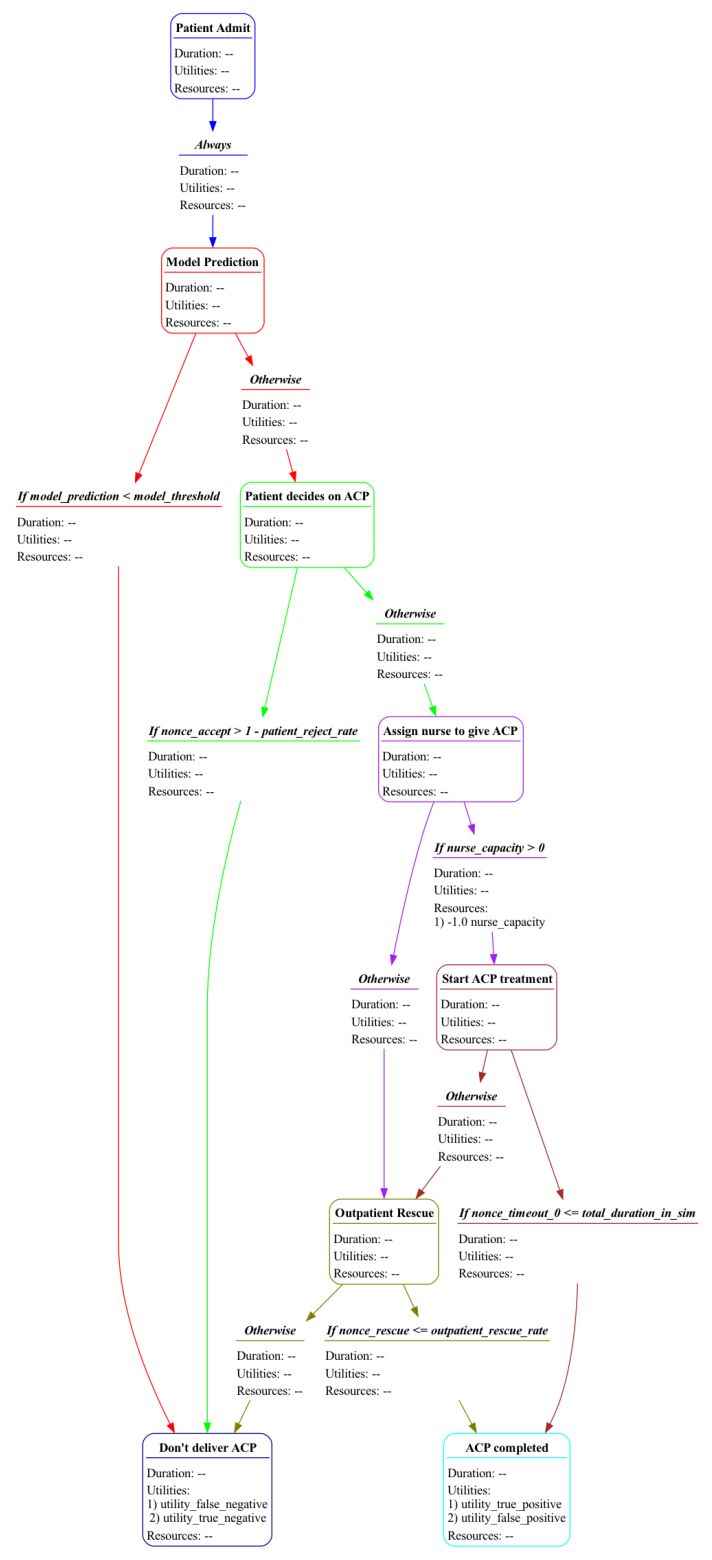

In [23]:
yaml: dict = aplusml.load_config(PATH_TO_YAML)
simulation: aplusml.Simulation = aplusml.create_simulation_from_config(yaml)
simulation.metadata['path_to_properties'] = PATH_TO_PATIENT_PROPERTIES
simulation.draw_workflow_diagram()

# Load Patients + Model Predictions

First, we'll load the CSV containing our patients from `ken_data_for_days.csv`.

Next, we initialize a `Patient` object for each row of our CSV, and store these objects in a list called `all_patients`.

Finally, we add each patient's properties to their `Patient` object.

In [24]:
df_patients = pd.read_csv(PATH_TO_PATIENT_PROPERTIES)
f"Shape of df_patients: {df_patients.shape}"

all_patients: list[aplusml.Patient] = [ 
    aplusml.Patient(row['id'], row['day']) 
    for _, row in df_patients.iterrows() 
]

all_patients: list[aplusml.Patient] = aplusml.create_patients_for_simulation(simulation, all_patients, random_seed = 0)
all_patients[0].properties

{'model_prediction': 0.0485028243335557,
 'total_duration_in_sim': 2,
 'patient_id': 0,
 'nonce_accept': 0.842263476923108,
 'nonce_rescue': 0.786526422249153,
 'nonce_timeout_0': 0,
 'nonce_timeout_1': 1.03531088083451,
 'nonce_timeout_2': 5.19398545076079,
 'nonce_timeout_3': 4.86679210488625,
 'nonce_timeout_4': 3.86699107272511,
 'nonce_timeout_100': 23.5839109867811,
 'ground_truth': 0}

# Run Simulations

Let's test different settings for the ACP workflow.

First, we write a function `reset_simulation()` that will reset our simulation to its "default" state between runs.

In [25]:
def reset_simulation(simulation: aplusml.Simulation, 
                     patients: list[aplusml.Patient],
                     random_seed: int = 0):
    # Reset simulation to "optimistic" case
    simulation.variables['outpatient_rescue_rate']['value'] = 0
    simulation.variables['nurse_capacity']['init_amount'] = 1e5
    simulation.variables['nurse_capacity']['max_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_duration'] = 1
    simulation.variables['model_threshold']['value'] = 0.5
    simulation.variables['patient_reject_rate']['value'] = 0
    simulation.states['timeout_func'].transitions[0]._if = 'nonce_timeout_0 <= total_duration_in_sim'
    # Resets patients to "optimistic" case
    # NOTE: This is necessary b/c simulation properties can change, which affects patients
    patients = aplusml.create_patients_for_simulation(simulation, patients, random_seed = random_seed)
    return patients

Next, we need to specify the model thresholds we want to test and the utilities associated with each outcome.

In [26]:
THRESHOLDS = ([0] + list(np.unique([p.properties['model_prediction'] for p in all_patients])) + [1])

UTILITIES = {
    'tp' : simulation.variables['utility_true_positive']['value'],
    'fp' : simulation.variables['utility_false_positive']['value'],
    'tn' : simulation.variables['utility_true_negative']['value'],
    'fn' : simulation.variables['utility_false_negative']['value'],
}

## Baseline Model

Next, we need to establish a baseline model -- we'll use the "optimistic" case where all model predictions are actionable.

In [6]:
all_patients = reset_simulation(simulation, all_patients)
baseline_df = aplusml.test_diff_thresholds(simulation, all_patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp'])
baseline_df['label'] = 'optimistic'

## Rejection Rate

Goal: Measure how different rejection rates affect our model's utility.

In [7]:
all_patients = reset_simulation(simulation, all_patients)
values = [.1, .2, .3, ]
rejection_df = aplusml.run_test(simulation, all_patients, 
         [f"{int(x * 100)}%" for x in values ],
         [{
             'patient_reject_rate' : {
                 **simulation.variables['patient_reject_rate'],
                 'value' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label: aplusml.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

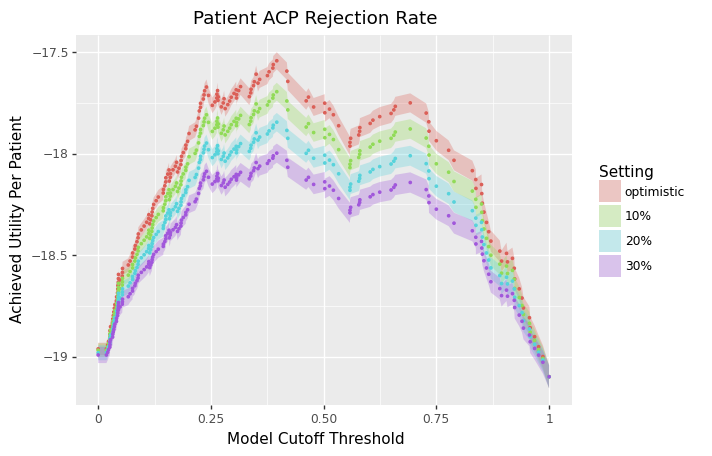

<ggplot: (8768306081291)>

In [8]:
aplusml.plot.plot_mean_utility_v_threshold('Patient ACP Rejection Rate', rejection_df)

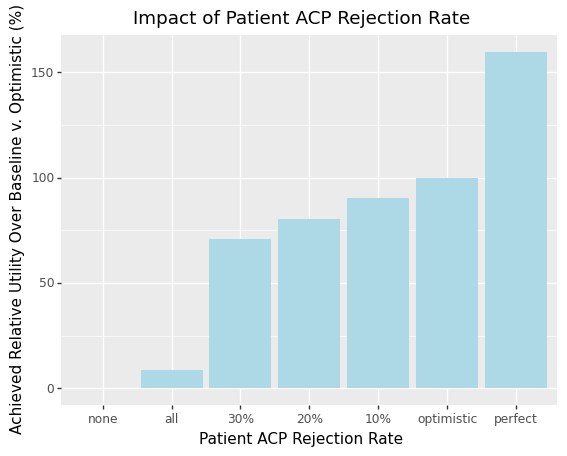

<ggplot: (8768269720183)>

In [9]:
plot_avg_utilities = {
    label: rejection_df[rejection_df['label'] == label]['mean_utility'].max() for label in rejection_df['label'].unique()
} | aplusml.get_unit_utility_baselines(all_patients, UTILITIES)
aplusml.plot.plot_bar_mean_utilities('Patient ACP Rejection Rate', plot_avg_utilities)

## Capacity Constraint

Goal: Measure how changing the number of patients that can go through ACP each day impacts model utility.

In [10]:
all_patients = reset_simulation(simulation, all_patients)
values = [ 0, 1, 2, 3, 4, 5, ]
cap_df = aplusml.run_test(simulation, all_patients, 
         [f"{x}" for x in values ],
         [{
             'nurse_capacity' : {
                 **simulation.variables['nurse_capacity'],
                 'init_amount' : x,
                 'max_amount' : x,
                 'refill_amount' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label : aplusml.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

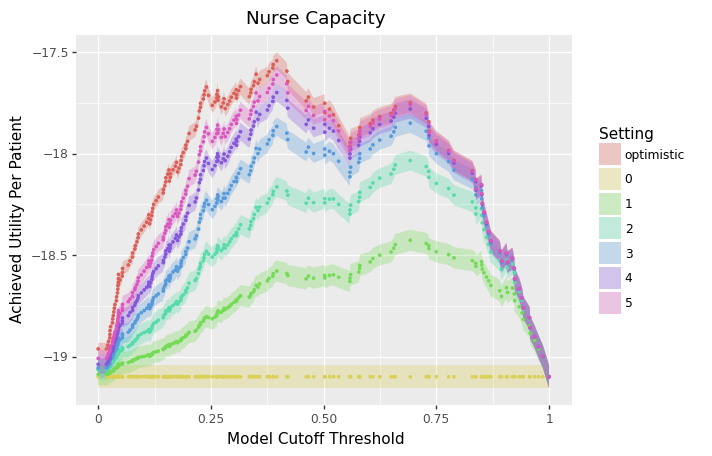

<ggplot: (8768307814292)>

In [11]:
aplusml.plot.plot_mean_utility_v_threshold('Nurse Capacity', cap_df)

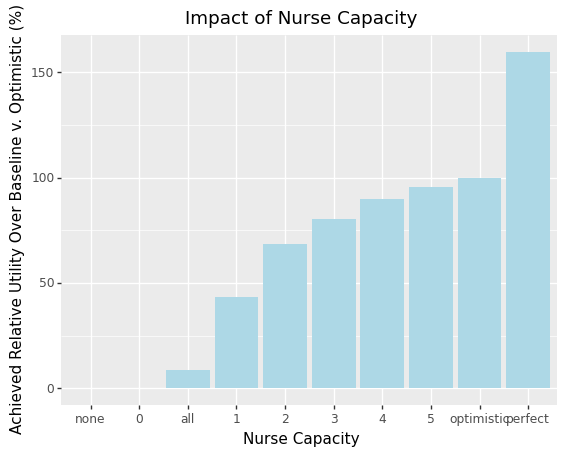

<ggplot: (8768289919493)>

In [12]:
plot_avg_utilities = {
    label: cap_df[cap_df['label'] == label]['mean_utility'].max() for label in cap_df['label'].unique()
} | aplusml.get_unit_utility_baselines(all_patients, UTILITIES)
aplusml.plot.plot_bar_mean_utilities('Nurse Capacity', plot_avg_utilities)

## ACP Timeout

Goal: Measure how changing the mean time to complete ACP affects model utility.

In [13]:
all_patients = reset_simulation(simulation, all_patients)
values = [ 1, 2, 3, 4, ]
def _run_timeout(sim, patients, label):
    sim.states['timeout_func'].transitions[0]._if = f"nonce_timeout_{label} <= total_duration_in_sim"
    return aplusml.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp'])
timeout_df = aplusml.run_test(simulation, all_patients,
         [f"{x}" for x in values ],
         [{
         } for x in values ],
         baseline_df, 
         _run_timeout)

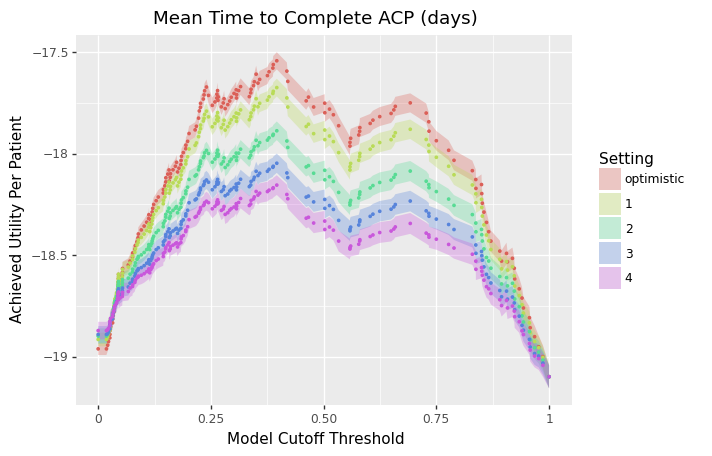

<ggplot: (8768153838568)>

In [14]:
aplusml.plot.plot_mean_utility_v_threshold('Mean Time to Complete ACP (days)', timeout_df)

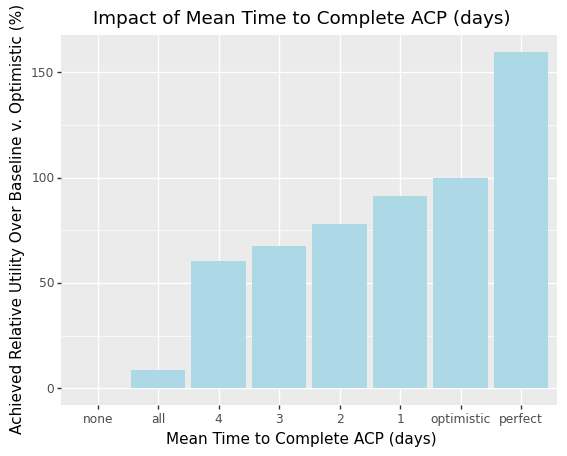

<ggplot: (8768274535265)>

In [15]:
plot_avg_utilities = {
    label: timeout_df[timeout_df['label'] == label]['mean_utility'].max() for label in timeout_df['label'].unique()
} | aplusml.get_unit_utility_baselines(all_patients, UTILITIES)
aplusml.plot.plot_bar_mean_utilities('Mean Time to Complete ACP (days)', plot_avg_utilities)

## Outpatient Rescue

Goal: Test how changing the outpatient rescue rate affects model utility.

In [16]:
all_patients = reset_simulation(simulation, all_patients)
simulation.variables['nurse_capacity']['init_amount'] = 3
simulation.variables['nurse_capacity']['max_amount'] = 3
simulation.variables['nurse_capacity']['refill_amount'] = 3
simulation.variables['patient_reject_rate']['value'] = 0.1
simulation.states['timeout_func'].transitions[0]._if = f"nonce_timeout_2 <= total_duration_in_sim"
values = [ 0, 0.5, 1, ]
rescue_df = aplusml.run_test(simulation, all_patients,
         [f"{int(100 * x)}%" for x in values ],
         [{
             'outpatient_rescue_rate' : {
                 **simulation.variables['outpatient_rescue_rate'],
                 'value' : x,
             }
         } for x in values ],
         baseline_df, 
         lambda sim, patients, label: aplusml.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

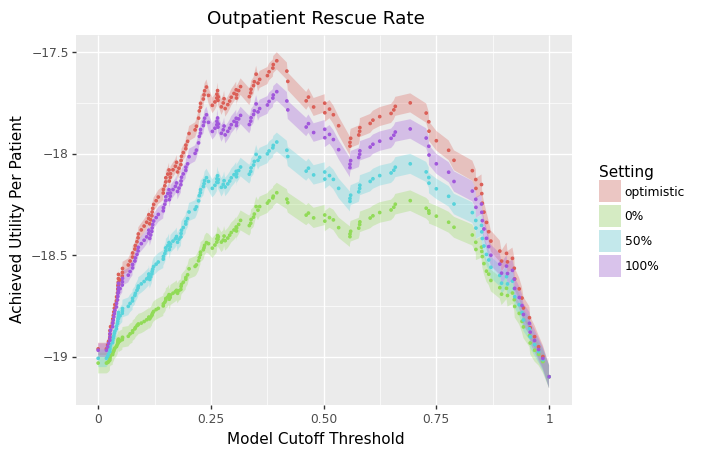

<ggplot: (8768152132705)>

In [17]:
aplusml.plot.plot_mean_utility_v_threshold('Outpatient Rescue Rate', rescue_df)

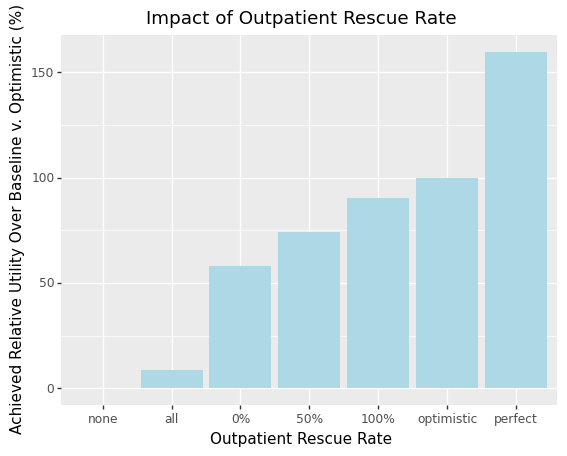

<ggplot: (8768291651359)>

In [18]:
plot_avg_utilities = {
    label: rescue_df[rescue_df['label'] == label]['mean_utility'].max() for label in rescue_df['label'].unique()
} | aplusml.get_unit_utility_baselines(all_patients, UTILITIES)
aplusml.plot.plot_bar_mean_utilities('Outpatient Rescue Rate', plot_avg_utilities)

# Measure Model Utility

Print plots summarizing model utilities

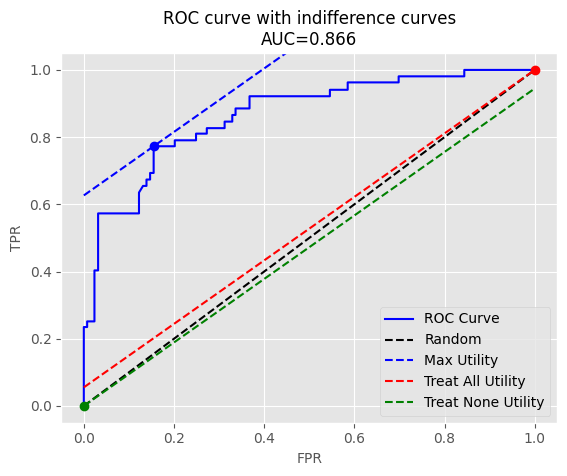

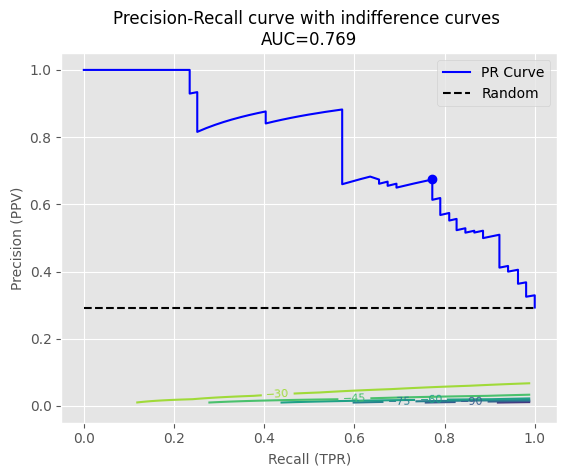

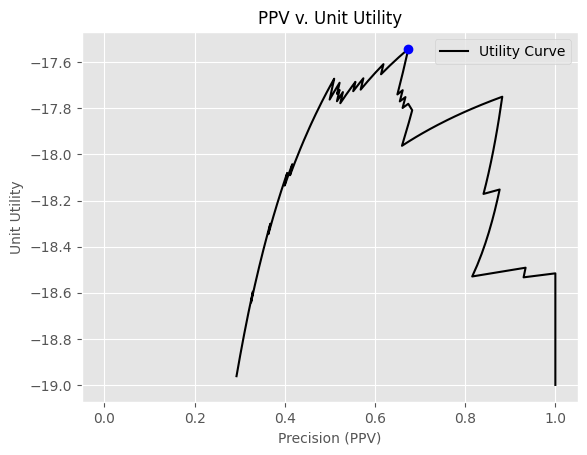

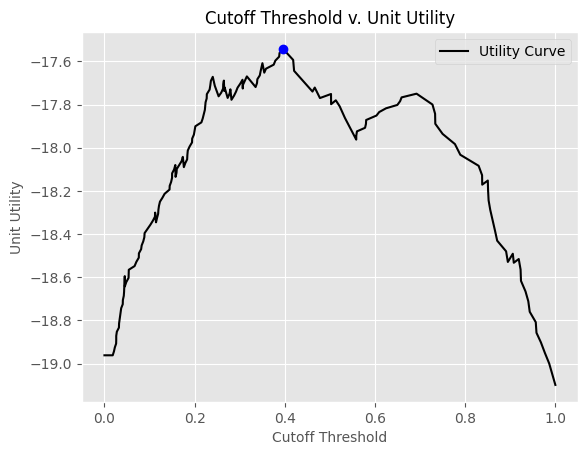

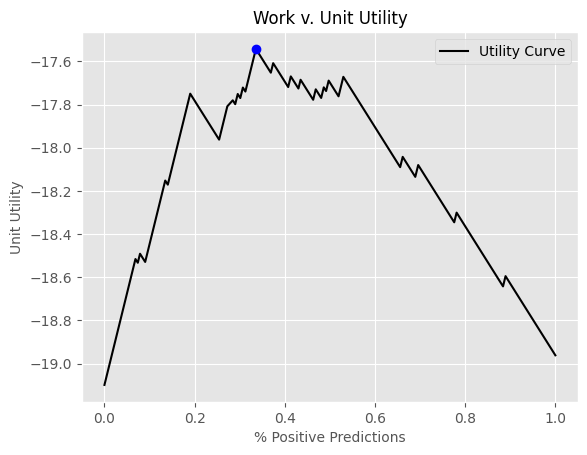

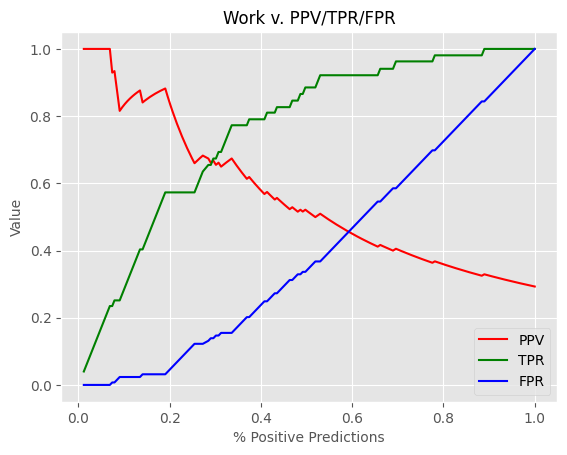

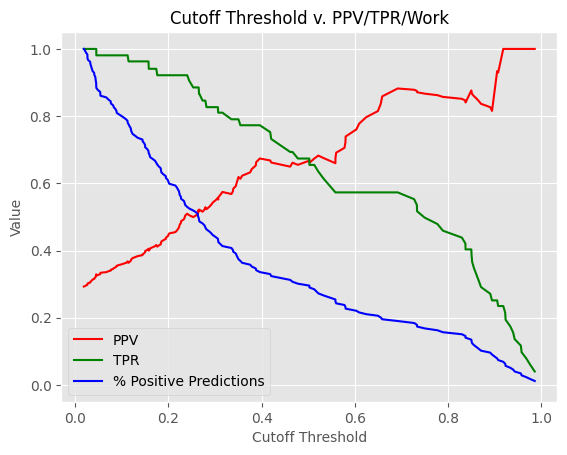

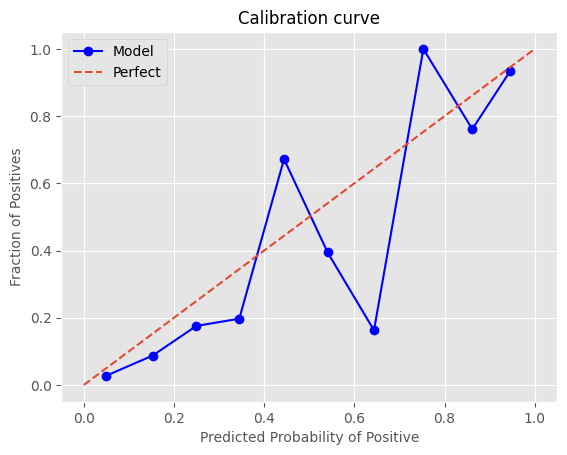

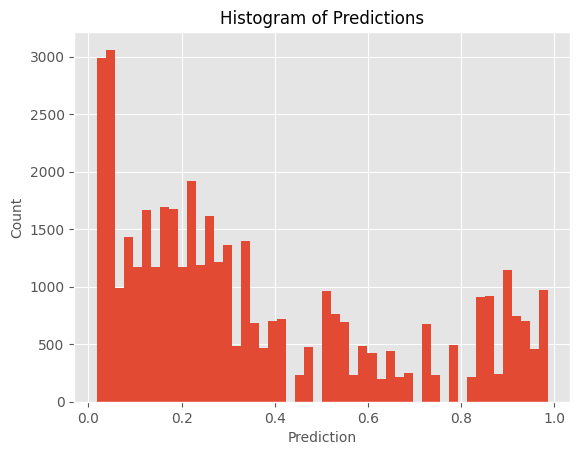

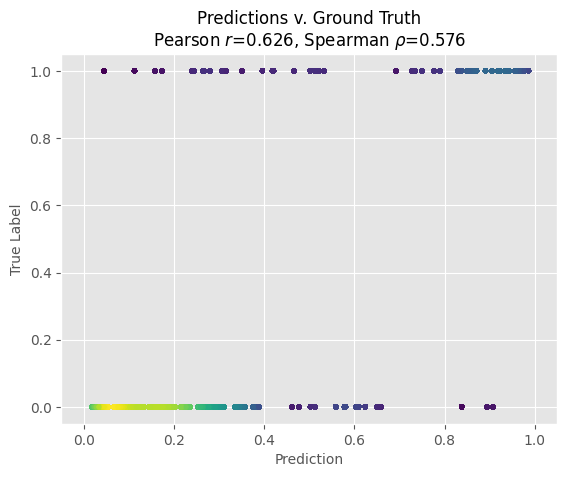

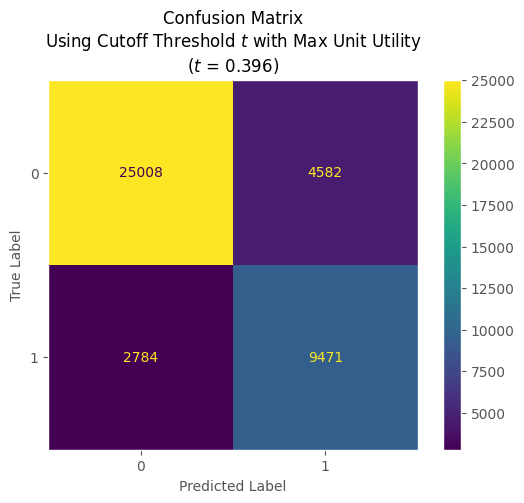

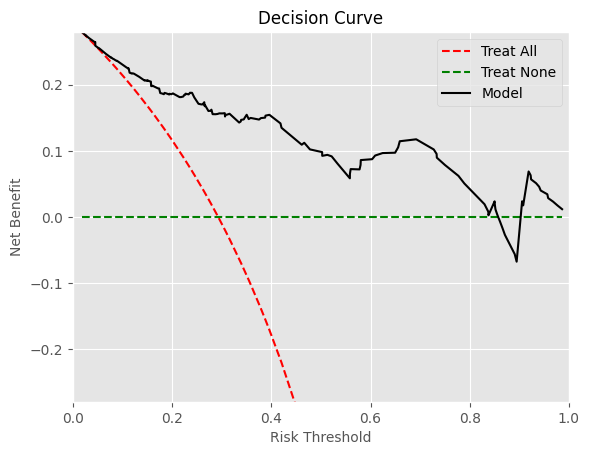

In [19]:
aplusml.plot.make_model_utility_plots(df_patients, UTILITIES, is_show = True)

# Line graph (Figure 2)

In [20]:
all_patients = reset_simulation(simulation, all_patients)
simulation.variables['patient_reject_rate']['value'] = 0.1
simulation.states['timeout_func'].transitions[0]._if = f"nonce_timeout_2 <= total_duration_in_sim"
values = [ 0, 0.5, 1, ]
capacity_values = [ 1, 2, 3, 4, 5, ]
rescue_values = [ 0, 0.5, 1, ]
combined_df = aplusml.run_test(simulation, all_patients,
         [f"{x},{y}" for x in capacity_values for y in rescue_values],
         [{
             'outpatient_rescue_rate' : {
                 **simulation.variables['outpatient_rescue_rate'],
                 'value' : y,
             },
             'nurse_capacity' : {
                 **simulation.variables['nurse_capacity'],
                 'init_amount' : x,
                 'max_amount' : x,
                 'refill_amount' : x,
             }
         } for x in capacity_values for y in rescue_values ],
         baseline_df, 
         lambda sim, patients, label: aplusml.test_diff_thresholds(sim, patients, THRESHOLDS, positive_outcome_state_ids=['complete_acp']))

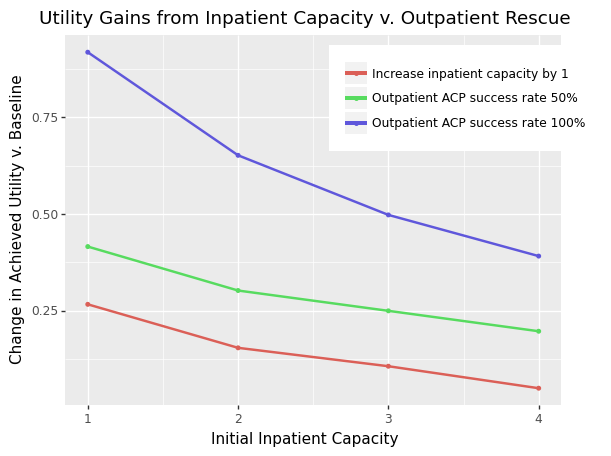

<ggplot: (8768291519095)>

In [21]:
df = combined_df.groupby('label', as_index=False).agg({
    'label' : 'first',
    'mean_utility' : 'max',
})
rows = []
for idx, row in df.iterrows():
    if row['label'] == 'optimistic': continue
    capacity = int(row['label'].split(',')[0])
    rescue_rate = float(row['label'].split(',')[1])
    if rescue_rate != 0:
        baseline_utility = df[df['label'] == f"{capacity},0"]['mean_utility'].values[0]
        if capacity > 4: 
            continue
        rows.append({
            'line' : f"rescue={rescue_rate}",
            'x' : capacity,
            'y' : row['mean_utility'] - baseline_utility,
        })
    else:
        if capacity > 1:
            baseline_utility = df[df['label'] == f"{capacity - 1},0"]['mean_utility'].values[0]
            rows.append({
                'line' : f"capacity=+1",
                'x' : capacity - 1,
                'y' : row['mean_utility'] - baseline_utility,
            })
df = pd.DataFrame(rows)

aplusml.plot.plot_line_compare_multiple_settings('Utility Gains from Inpatient Capacity v. Outpatient Rescue',
                                                    df,
                                                    'Initial Inpatient Capacity',
                                                    ['Increase inpatient capacity by 1',
                                                    'Outpatient ACP success rate 50%',
                                                    'Outpatient ACP success rate 100%',
                                                    ])
        